In [13]:
import pandas as pd
import numpy as np
import pandahouse as ph
from read_db.CH import Getch
import matplotlib.pyplot as plt
import seaborn as sns
import pylab 
from scipy import stats

sns.set(font_scale=1.2)

##### АА-теста с '2022-04-17' по '2022-04-23'. 
 - Нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. 
 - На каждой итерации вам нужно сформировать подвыборки с повторением в 500 юзеров из 2 и 3 экспериментальной группы. 
 - Провести сравнение этих подвыборок t-testом.

1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p values оказался меньше либо равен 0.05.

3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.


In [14]:
df = Getch("""
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220520.feed_actions 
WHERE toDate(time) between '2022-04-17' and '2022-04-23'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
""").df

In [15]:
exp_group2 = df[df['exp_group'] == 2]['ctr']

In [16]:
exp_group3 = df[df['exp_group'] == 3]['ctr']

In [17]:
len(exp_group2), len(exp_group3)

(8480, 8569)

<AxesSubplot:xlabel='ctr', ylabel='Count'>

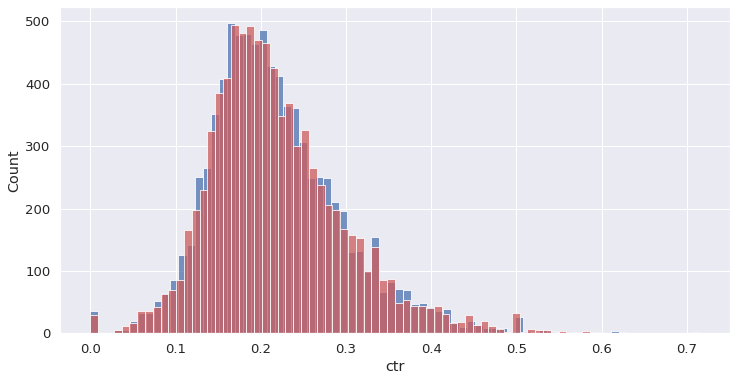

In [18]:
plt.figure(figsize=(12,6))
sns.histplot(exp_group2)
sns.histplot(exp_group3, color = 'indianred')

4.83% p-values оказался меньше либо равен 0.05


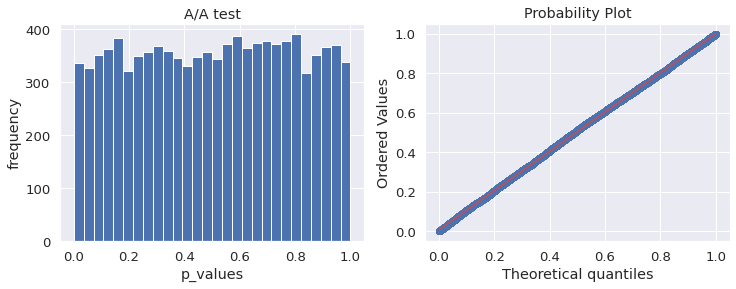

In [19]:
res = []
n = 10000
sample = 500
alpha = 0.05

for _ in range(n):
    _, p_value = stats.ttest_ind(a=exp_group2.sample(sample,replace=True).values, 
                                 b=exp_group2.sample(sample,replace=True).values, 
                                 equal_var=False)
    res.append((p_value, p_value <= alpha))
    
t = pd.DataFrame(res)
t = t.rename(columns={0: "p_value", 1: "p_value<=0.05"})

p_value = round(t['p_value<=0.05'].mean() * 100,2)

print(f'{p_value}% p-values оказался меньше либо равен 0.05')
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(t['p_value'], bins=28)
plt.xlabel('p_values')
plt.ylabel('frequency')
plt.title("A/A test")

plt.subplot(1,2,2)
stats.probplot(t['p_value'], dist="uniform", plot=pylab)
pylab.show()

##### Вывод:
- Получили равномерное распределение p-values
- Процент ложно положительных срабатываний примерно равен alpha
- Сплитование работает корректно, можно приступать к A/B тесту